# Import Library

In [2]:
%pip install ultralytics -q
%pip install segmentation_models_pytorch -q
%pip install torchmetrics -q
%pip install torch torchvision torchaudio -q
%pip install timm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.7 MB/s eta 0:00:00


In [3]:
import os
import yaml
import random
import shutil
import pandas as pd
import numpy as np
from IPython.display import display
from collections import Counter, defaultdict
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from glob import glob
from google.colab.patches import cv2_imshow
from google.colab import files
from google.colab import drive

In [4]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchmetrics.classification import JaccardIndex

import tensorflow as tf
import torch
import urllib
import torch.nn as nn
import torch.optim as optim
import albumentations as A
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Data Loading

## Unzip Coin Dataset

In [4]:
!unzip coin_segmentation_with_1000_rupiah_v2.zip

Archive:  coin_segmentation_with_1000_rupiah_v2.zip
   creating: coin_segmentation_with_1000_rupiah/
   creating: coin_segmentation_with_1000_rupiah/images/
  inflating: coin_segmentation_with_1000_rupiah/images/001_jpg.rf.b0c6caab09f03ab5bbcff165fc6d6738.jpg  
  inflating: coin_segmentation_with_1000_rupiah/images/00334d13-4962-4b53-9dd2-121f8f000beb_jpg.rf.1651dfbe8f5363caae395c449145fbd4.jpg  
  inflating: coin_segmentation_with_1000_rupiah/images/0044de2f-d45b-4526-99eb-adf982d98b05_jpg.rf.fbe4758ad4043f0e62388892f841ebd8.jpg  
  inflating: coin_segmentation_with_1000_rupiah/images/00db272e-1d5f-4ff1-9cd6-1d8be42cb1a5_jpg.rf.7916125317f9729a47b4843909be0b98.jpg  
  inflating: coin_segmentation_with_1000_rupiah/images/08665546-9cd5-413b-9eb8-baebbb7e34fd_jpg.rf.66b58f2e034822d09ff078fe6b970863.jpg  
  inflating: coin_segmentation_with_1000_rupiah/images/0ba4fa31-913c-45be-9e59-bc14fe4f324e_jpg.rf.9620d66a1e0905cbd072f6d0706bd71d.jpg  
  inflating: coin_segmentation_with_1000_rupiah/

# Data Splitting

In [5]:
# --- paths ---
base_dir = "coin_segmentation_with_1000_rupiah"
img_dir = os.path.join(base_dir, "images")
lbl_dir = os.path.join(base_dir, "labels")

# output folder
output_dir = "dataset_split"
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

# --- make folders ---
for split in [train_dir, val_dir]:
    os.makedirs(os.path.join(split, "images"), exist_ok=True)
    os.makedirs(os.path.join(split, "labels"), exist_ok=True)

# --- get all images ---
images = sorted(glob(os.path.join(img_dir, "*.jpg"))) + sorted(glob(os.path.join(img_dir, "*.png")))
random.shuffle(images)

# --- split 90/10 ---
split_idx = int(len(images) * 0.8)
train_images = images[:split_idx]
val_images = images[split_idx:]

def copy_split(image_list, split_name):
    for img_path in image_list:
        img_name = os.path.basename(img_path)
        label_name = os.path.splitext(img_name)[0] + ".txt"

        src_label = os.path.join(lbl_dir, label_name)
        dst_img = os.path.join(output_dir, split_name, "images", img_name)
        dst_lbl = os.path.join(output_dir, split_name, "labels", label_name)

        shutil.copy(img_path, dst_img)
        if os.path.exists(src_label):
            shutil.copy(src_label, dst_lbl)

# --- copy files ---
copy_split(train_images, "train")
copy_split(val_images, "val")

print(f"✅ Total images: {len(images)}")
print(f"✅ Train: {len(train_images)}, Val: {len(val_images)}")
print(f"📂 Output saved to: {output_dir}")

✅ Total images: 226
✅ Train: 180, Val: 46
📂 Output saved to: dataset_split


# Model Training

## Create data.yaml

In [6]:
data = {
    "path": "dataset_split",
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "nc": 1,
    "names": [
        "coin",
    ]
}

with open("data.yaml", "w", encoding="utf-8") as f:
    yaml.dump(data, f, allow_unicode=True, sort_keys=False)

print("✅ data.yaml created successfully!")

✅ data.yaml created successfully!


## Training

In [ ]:
!yolo segment train model=yolo11s-seg.pt data=data.yaml epochs=50 imgsz=640 augment=True\
    hsv_h=0.015 hsv_s=0.7 hsv_v=0.4 degrees=10 translate=0.1 scale=0.5 shear=2.0 flipud=0.2 fliplr=0.5 mosaic=1.0 mixup=0.2

New https://pypi.org/project/ultralytics/8.3.216 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.215 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.2, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False

In [ ]:
!zip coin_segmentation_model.zip -r runs/segment/train

  adding: runs/segment/train/ (stored 0%)
  adding: runs/segment/train/train_batch0.jpg (deflated 3%)
  adding: runs/segment/train/MaskP_curve.png (deflated 20%)
  adding: runs/segment/train/train_batch401.jpg (deflated 8%)
  adding: runs/segment/train/train_batch2.jpg (deflated 2%)
  adding: runs/segment/train/weights/ (stored 0%)
  adding: runs/segment/train/weights/best.pt (deflated 8%)
  adding: runs/segment/train/weights/last.pt (deflated 8%)
  adding: runs/segment/train/BoxPR_curve.png (deflated 30%)
  adding: runs/segment/train/val_batch1_labels.jpg (deflated 15%)
  adding: runs/segment/train/val_batch0_labels.jpg (deflated 9%)
  adding: runs/segment/train/labels.jpg (deflated 39%)
  adding: runs/segment/train/results.png (deflated 6%)
  adding: runs/segment/train/val_batch0_pred.jpg (deflated 8%)
  adding: runs/segment/train/confusion_matrix.png (deflated 38%)
  adding: runs/segment/train/MaskR_curve.png (deflated 19%)
  adding: runs/segment/train/train_batch1.jpg (deflated 3%)

# Predict on Photo

## Get cm/pixel from Coin

### Unzip Download Model (If Need)

In [18]:
!unzip /content/coin_segmentation_model_v3.zip

Archive:  /content/coin_segmentation_model_v3.zip
   creating: runs/segment/train/
  inflating: runs/segment/train/train_batch0.jpg  
  inflating: runs/segment/train/MaskP_curve.png  
  inflating: runs/segment/train/train_batch481.jpg  
  inflating: runs/segment/train/train_batch482.jpg  
  inflating: runs/segment/train/train_batch2.jpg  
  inflating: runs/segment/train/train_batch480.jpg  
   creating: runs/segment/train/weights/
  inflating: runs/segment/train/weights/best.pt  
  inflating: runs/segment/train/weights/last.pt  
  inflating: runs/segment/train/BoxPR_curve.png  
  inflating: runs/segment/train/val_batch1_labels.jpg  
  inflating: runs/segment/train/val_batch0_labels.jpg  
  inflating: runs/segment/train/labels.jpg  
  inflating: runs/segment/train/results.png  
  inflating: runs/segment/train/val_batch0_pred.jpg  
  inflating: runs/segment/train/confusion_matrix.png  
  inflating: runs/segment/train/MaskR_curve.png  
  inflating: runs/segment/train/train_batch1.jpg  
  

### Load & Predict an Image

In [13]:
img_path = "/content/food-coin-4.jpg"

In [19]:
model = YOLO("runs/segment/train/weights/best.pt")
results = model.predict(img_path)


image 1/1 /content/food-coin-4.jpg: 640x480 1 coin, 93.8ms
Speed: 4.5ms preprocess, 93.8ms inference, 334.7ms postprocess per image at shape (1, 3, 640, 480)


### Display Result

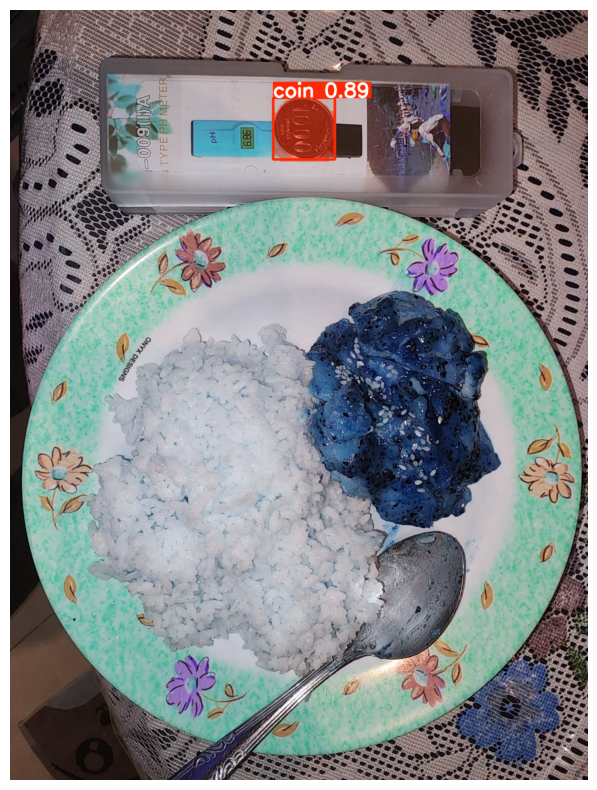

In [20]:
img_result = results[0].plot()

plt.figure(figsize=(10, 10))
plt.imshow(img_result)
plt.axis("off")
plt.show()

### Get Class Name

In [21]:
class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
class_names = [results[0].names[class_id] for class_id in class_ids]

class_names

['coin']

### Get Confidence

In [22]:
confidences = results[0].boxes.conf.cpu().numpy()
confidences = confidences.tolist()

confidences

[0.8910809755325317]

### Get Mask & Convert to Black White

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
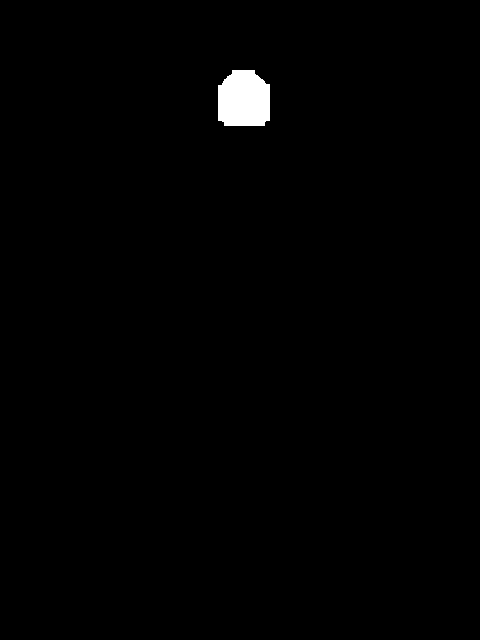

In [23]:
masks = results[0].masks.data.cpu().numpy()
masks = ((masks > 0.5).astype(np.uint8)) * 255

for mask in masks:
  display(mask)

### Calculate Length & Width in Pixel

In [24]:
coin_sizes = []

for mask in masks:
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnt = max(contours, key=cv2.contourArea)

  leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
  rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
  topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
  bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])

  length_px = np.linalg.norm(np.array(leftmost) - np.array(rightmost))
  width_px = np.linalg.norm(np.array(topmost) - np.array(bottommost))

  coin_sizes.append({"length": length_px, "width": width_px})

for idx, size in enumerate(coin_sizes):
  print(f"{class_names[idx]}: Length: {size['length']} px | Width: {size['width']} px")

coin: Length: 61.85466837676846 px | Width: 55.57877292636101 px


### Calculate cm/pixel

In [25]:
length_pixel = coin_sizes[0]["length"]
width_pixel = coin_sizes[0]["width"]
coin_real_diameter = 2.41

cm_per_px_length = coin_real_diameter / length_pixel
cm_per_px_width = coin_real_diameter / width_pixel

print(f"Length: {cm_per_px_length} cm/px")
print(f"Width: {cm_per_px_width} cm/px")

Length: 0.03896229764454051 cm/px
Width: 0.043361878521375866 cm/px


## Get cm/depth unit with MiDaS

### Load MiDaS

In [5]:
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:11<00:00, 123MB/s]


In [6]:
transform = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = transform.dpt_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


### Load Image

In [14]:
img = cv2.imread(img_path)

if img is None:
    print(f"Error: Could not load image from {img_path}")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_batch = transform(img).to("cpu")

### Predict Image

In [15]:
with torch.no_grad():
    prediction = midas(input_batch)

# Resize back to original image size
prediction = torch.nn.functional.interpolate(
    prediction.unsqueeze(1),
    size=img.shape[:2],
    mode="bicubic",
    align_corners=False,
).squeeze()

depth_map = prediction.cpu().numpy()

### Display Result

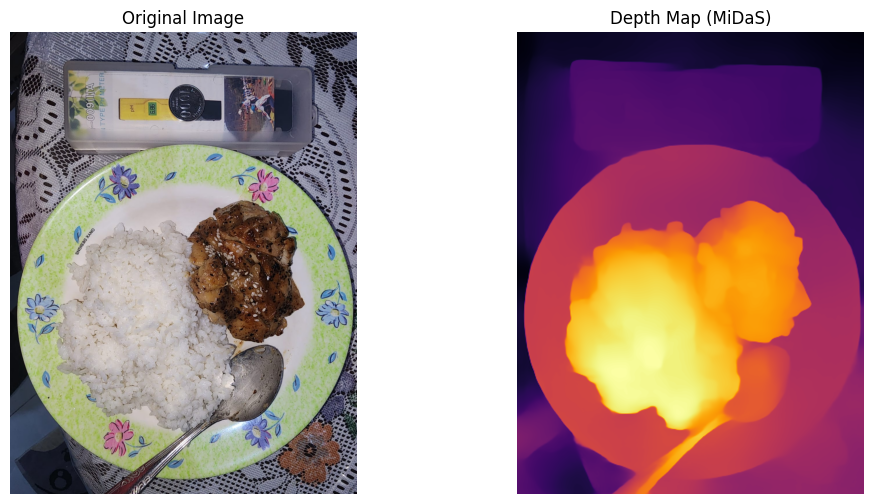

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(depth_map, cmap='inferno')
plt.title("Depth Map (MiDaS)")
plt.axis('off')

plt.show()

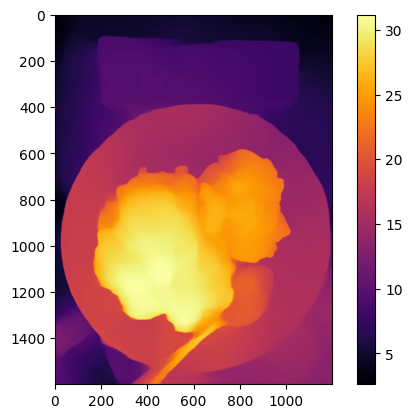

In [17]:
plt.imshow(depth_map, cmap="inferno")
plt.colorbar()
plt.show()

### Resize Coin Mask

In [26]:
coin_mask = masks[0]

# Resize coin mask to original image size
h, w = results[0].orig_shape
coin_mask_resize = cv2.resize(coin_mask, (w, h), interpolation=cv2.INTER_NEAREST)

### Get Median of Coin Mask Depth Value

In [27]:
coin_depth = np.median(depth_map[coin_mask_resize > 0])

coin_depth

np.float32(9.085244)

### Calculate cm/depth unit

In [32]:
bg_only = (coin_mask_resize == 0)
near_coin = cv2.dilate(coin_mask_resize, np.ones((25,25), np.uint8))  # around coin mask
ring_bg = np.logical_and(near_coin, bg_only)

bg_depth = np.median(depth_map[ring_bg])

bg_depth

np.float32(8.968908)

In [33]:
delta = abs(coin_depth - bg_depth)
print(f"Coin median depth: {coin_depth:.4f}")
print(f"Background median depth: {bg_depth:.4f}")
print(f"Depth difference (Δ): {delta:.4f}")

Coin median depth: 9.0852
Background median depth: 8.9689
Depth difference (Δ): 0.1163


In [35]:
coin_real_thickness = 0.16
cm_per_depth_unit = coin_real_thickness / delta

print(f"Depth: {cm_per_depth_unit} cm/depth unit")

Depth: 1.3753281831741333 cm/depth unit
